In [146]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

In [147]:
# Setup Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [148]:
!pip install -q findspark
!pip install pyspark

In [149]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [150]:
from pyspark.sql import SparkSession

In [151]:
APP_NAME = "Final_Project"

In [152]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [153]:
spark

EDA

In [154]:
#import dependencies
from google.colab import files
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import asc
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when, lit, col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession 
from pyspark.sql.functions import * 
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.classification import LinearSVC


In [155]:
#uploading the song data file
uploaded = files.upload()

Saving song_data.csv to song_data (3).csv


In [156]:
#turning the file into a pyspark dataframe
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
file_type = "csv"

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter).csv("song_data.csv")
  
df.show(5)

+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|           song_name|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|
+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|Boulevard of Brok...|             73|          262333|     0.00552|       0.496| 0.682|         2.94E-5|  8|  0.0589|  -4.095|       1.0|     0.0294| 167.06|           4.0|        0.474|
|          In The End|             66|          216933|      0.0103|       0.542| 0.853|             0.0|  3|   0.108|  -6.407|       0.0|     0.0498|105.256|           4.0|         0.37|
|   Seven Nation Army|             76|          231733|     

In [157]:
df.printSchema()

root
 |-- song_name: string (nullable = true)
 |-- song_popularity: string (nullable = true)
 |-- song_duration_ms: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- audio_mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- audio_valence: double (nullable = true)



In [158]:
df.show(5)

+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|           song_name|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|
+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|Boulevard of Brok...|             73|          262333|     0.00552|       0.496| 0.682|         2.94E-5|  8|  0.0589|  -4.095|       1.0|     0.0294| 167.06|           4.0|        0.474|
|          In The End|             66|          216933|      0.0103|       0.542| 0.853|             0.0|  3|   0.108|  -6.407|       0.0|     0.0498|105.256|           4.0|         0.37|
|   Seven Nation Army|             76|          231733|     

In [159]:
df.describe().show()

+-------+--------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|summary|           song_name|   song_popularity| song_duration_ms|      acousticness|       danceability|             energy|   instrumentalness|               key|           liveness|          loudness|         audio_mode|        speechiness|             tempo|    time_signature|      audio_valence|
+-------+--------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|  count|               18835|             18835|            18835|             18835|     

In [160]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-----+--------------+-------------+
|song_name|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|tempo|time_signature|audio_valence|
+---------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-----+--------------+-------------+
|        0|              0|               0|           0|           0|     0|               0|  0|       0|       0|         0|          0|    0|             0|            0|
+---------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-----+--------------+-------------+



In [161]:
df.sort(asc("danceability")).show(10)

+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|           song_name|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|
+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|Gina Rodriguez - ...|              0|           12000|         0.7|         0.0| 0.493|             0.0|  7|   0.457|  -6.102|       1.0|        0.0|    0.0|           0.0|          0.0|
|                Aura|             50|          102536|      0.0774|         0.0|  0.56|           0.963| 11|   0.589|  -9.866|       1.0|        0.0|    0.0|           0.0|          0.0|
|   Portugal (A Lift)|             47|          408085|     

In [162]:
df.select('time_signature').distinct().count()

6

In [163]:
#Danceabilities Deviation
quantile = df.approxQuantile(['danceability'], [0.25, 0.5, 0.75], 0)
quantile_25 = quantile[0][0]
quantile_50 = quantile[0][1]
quantile_75 = quantile[0][2]
print('danceability_25: '+str(quantile_25))
print('danceability_50: '+str(quantile_50))
print('danceability_75: '+str(quantile_75))

danceability_25: 0.533
danceability_50: 0.645
danceability_75: 0.748


In [164]:
#Audio Valence Deviation
quantile = df.approxQuantile(['audio_valence'], [0.25, 0.5, 0.75], 0)
quantile_25 = quantile[0][0]
quantile_50 = quantile[0][1]
quantile_75 = quantile[0][2]
print('audio_valence_quantile_25: '+str(quantile_25))
print('audio_valence_quantile_50: '+str(quantile_50))
print('audio_valence_quantile_75: '+str(quantile_75))

audio_valence_quantile_25: 0.335
audio_valence_quantile_50: 0.527
audio_valence_quantile_75: 0.725


In [165]:
df.agg({'danceability': 'max'}).show()

+-----------------+
|max(danceability)|
+-----------------+
|            0.987|
+-----------------+



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


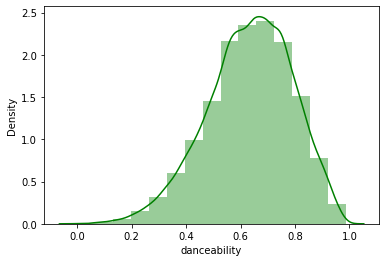

In [166]:
#the distribution of the dancability column
dfPandas = df.toPandas()
sns.distplot (dfPandas.danceability, color = 'g', bins = 15)

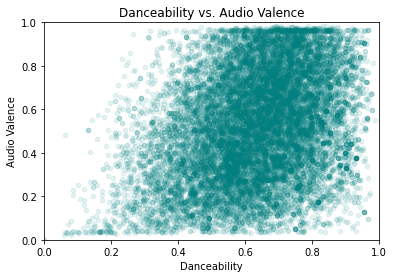

In [167]:
ax = dfPandas.plot(kind='scatter', x= 'danceability', y = 'audio_valence', c='teal', alpha = 0.10)
ax.set_title('Danceability vs. Audio Valence')
ax.set_xlabel('Danceability')
ax.set_ylabel('Audio Valence')
plt.axis([0, 1, -0, 1])
plt.suptitle('')
plt.show()

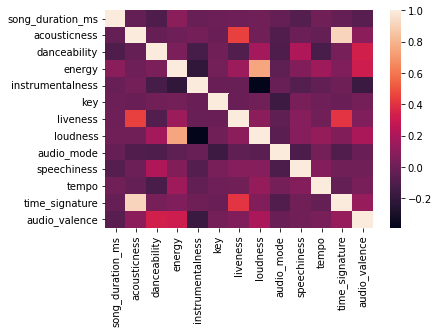

In [168]:
sns.heatmap(dfPandas.corr())

Methodology

In [169]:
df.show(5)

+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|           song_name|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|
+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|Boulevard of Brok...|             73|          262333|     0.00552|       0.496| 0.682|         2.94E-5|  8|  0.0589|  -4.095|       1.0|     0.0294| 167.06|           4.0|        0.474|
|          In The End|             66|          216933|      0.0103|       0.542| 0.853|             0.0|  3|   0.108|  -6.407|       0.0|     0.0498|105.256|           4.0|         0.37|
|   Seven Nation Army|             76|          231733|     

In [170]:
df = df.drop("song_name")
df.show(5)

+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|
+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|             73|          262333|     0.00552|       0.496| 0.682|         2.94E-5|  8|  0.0589|  -4.095|       1.0|     0.0294| 167.06|           4.0|        0.474|
|             66|          216933|      0.0103|       0.542| 0.853|             0.0|  3|   0.108|  -6.407|       0.0|     0.0498|105.256|           4.0|         0.37|
|             76|          231733|     0.00817|       0.737| 0.463|           0.447|  0|   0.255|  -7.828|       1.0|     0.0792|123.881|           4.0|        0.324

In [171]:
df = df.withColumn("song_popularity",col("song_popularity").cast(IntegerType())) 
df.printSchema()

root
 |-- song_popularity: integer (nullable = true)
 |-- song_duration_ms: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- audio_mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- audio_valence: double (nullable = true)



In [172]:
df = df.na.drop("any")
dfAlt = df

df = df.withColumn("danceability", when(col("danceability") > 0.645,lit(1)).otherwise(lit(0)))
df.show(truncate=False)

+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|tempo  |time_signature|audio_valence|
+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|73             |262333          |0.00552     |0           |0.682 |2.94E-5         |8  |0.0589  |-4.095  |1.0       |0.0294     |167.06 |4.0           |0.474        |
|66             |216933          |0.0103      |0           |0.853 |0.0             |3  |0.108   |-6.407  |0.0       |0.0498     |105.256|4.0           |0.37         |
|76             |231733          |0.00817     |1           |0.463 |0.447           |0  |0.255   |-7.828  |1.0       |0.0792     |123.881|4.0           |0.324        

In [173]:
cols = ['song_popularity',
 'song_duration_ms',
 'acousticness',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'audio_mode',
 'speechiness',
 'tempo',
 'time_signature',
 'audio_valence']
stages= VectorAssembler(inputCols=cols, outputCol='features')

df = stages.transform(df)
df.show(5)

+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+--------------------+
|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|            features|
+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+--------------------+
|             73|          262333|     0.00552|           0| 0.682|         2.94E-5|  8|  0.0589|  -4.095|       1.0|     0.0294| 167.06|           4.0|        0.474|[73.0,262333.0,0....|
|             66|          216933|      0.0103|           0| 0.853|             0.0|  3|   0.108|  -6.407|       0.0|     0.0498|105.256|           4.0|         0.37|[66.0,216933.0,0....|
|             76|          231733|     0.00817|           1|

In [174]:
dfModel = df.select(['features', 'danceability'])
dfModel.show(5)

+--------------------+------------+
|            features|danceability|
+--------------------+------------+
|[73.0,262333.0,0....|           0|
|[66.0,216933.0,0....|           0|
|[76.0,231733.0,0....|           1|
|[74.0,216933.0,0....|           0|
|[56.0,223826.0,9....|           0|
+--------------------+------------+
only showing top 5 rows



In [175]:
dfModelB = dfModel.withColumnRenamed('danceability', 'label')
dfModelB.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[73.0,262333.0,0....|    0|
|[66.0,216933.0,0....|    0|
|[76.0,231733.0,0....|    1|
|[74.0,216933.0,0....|    0|
|[56.0,223826.0,9....|    0|
+--------------------+-----+
only showing top 5 rows



In [176]:
train,test= dfModel.randomSplit([0.75,0.25])
trainB,testB= dfModelB.randomSplit([0.75,0.25])
trainC,testC= dfModelB.randomSplit([0.75,0.25])

In [177]:
train.show(5)

+--------------------+------------+
|            features|danceability|
+--------------------+------------+
|(13,[1,2,3,5,6,7,...|           0|
|[0.0,80672.0,0.14...|           1|
|[0.0,102560.0,0.1...|           1|
|[0.0,110560.0,0.7...|           1|
|[0.0,120000.0,0.5...|           1|
+--------------------+------------+
only showing top 5 rows



In [178]:
trainB.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,80672.0,0.14...|    1|
|[0.0,120000.0,0.5...|    1|
|[0.0,139200.0,0.3...|    1|
|[0.0,139200.0,0.3...|    1|
|[0.0,141093.0,0.1...|    1|
+--------------------+-----+
only showing top 5 rows



### Logistic Regression

In [179]:
lr = LogisticRegression(labelCol = 'danceability', featuresCol = 'features', maxIter = 100, regParam = 0.001, elasticNetParam=1, standardization=True)

linearR = lr.fit(train)
best_model_lr = linearR.summary

In [180]:
best_model_lr.predictions.show(5)
print("Coefficients: " + str(linearR.coefficients))
print("Intercept: " + str(linearR.intercept))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+------------+--------------------+--------------------+----------+
|            features|danceability|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(13,[1,2,3,5,6,7,...|         0.0|[2.99172835699151...|[0.95219903960860...|       0.0|
|[0.0,80672.0,0.14...|         1.0|[-0.6709330811427...|[0.33828793981474...|       1.0|
|[0.0,102560.0,0.1...|         1.0|[-3.0787002314276...|[0.04399444989264...|       1.0|
|[0.0,110560.0,0.7...|         1.0|[1.69233332682757...|[0.84453076864868...|       0.0|
|[0.0,120000.0,0.5...|         1.0|[-0.9160770377551...|[0.28575789875591...|       1.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows

Coefficients: [0.0058238647246771314,-1.8997935833363025e-06,-1.8194098521046378,-4.440117365205191,0.6833512050366433,-0.0075205024883617634,-1.0479415981088016,0.1581230450

In [181]:
predictions_lr = linearR.transform(test)
predictions_lr.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|            features|danceability|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[0.0,139200.0,0.3...|           1|[-0.7183369132249...|[0.32775931105234...|       1.0|
|[0.0,141093.0,0.1...|           1|[-0.5675501979638...|[0.36180229583072...|       1.0|
|[0.0,141586.0,0.0...|           1|[-1.0472997840591...|[0.25974395340756...|       1.0|
|[0.0,149200.0,0.0...|           0|[1.14421280767822...|[0.75845227568200...|       0.0|
|[0.0,151062.0,0.4...|           1|[-0.7842187319106...|[0.31341136576878...|       1.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [182]:
predictions_lr.groupBy('danceability','prediction').count().show()

+------------+----------+-----+
|danceability|prediction|count|
+------------+----------+-----+
|           1|       0.0|  684|
|           0|       0.0| 1622|
|           1|       1.0| 1588|
|           0|       1.0|  762|
+------------+----------+-----+



In [183]:
#True Positive Rate = True Positives / (True Positives + False Negatives)
#Sensitivity = True Positives / (True Positives + False Negatives)
#False Positive Rate = False Positives / (False Positives + True Negatives)
#Specificity = True Negatives / (True Negatives + False Positives)
#False Positive Rate = 1 - Specificity

evaluatorLR = MulticlassClassificationEvaluator(labelCol="danceability", predictionCol="prediction",metricName="accuracy")
accuracyLR = evaluatorLR.evaluate(predictions_lr)

#precision
#tp/(tp + fp)
precisionLR = 1697/(1697 + 797)
recallLR = 1697/(1697 + 702)
f1LR = (2 *0.68 * 0.7)/(0.68 + 0.7)

print("The accuracy is:", accuracyLR)
print("The precision is:", precisionLR)
print("The recall is:", recallLR)
print("The f1 score is:", f1LR)

The accuracy is: 0.6894329896907216
The precision is: 0.6804330392943063
The recall is: 0.7073780741975824
The f1 score is: 0.6898550724637681


Random Forest

In [184]:
from pyspark.ml.classification import DecisionTreeClassifier# train our model using training data
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
modelRF = dt.fit(trainB)

# test our model and make predictions using testing data
predictionsRF = modelRF.transform(testB)
predictionsRF.show(5)

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(13,[1,2,3,5,6,7,...|    0|[2315.0,716.0]|[0.76377433190366...|       0.0|
|[0.0,102560.0,0.1...|    1|[638.0,2173.0]|[0.22696549270722...|       1.0|
|[0.0,110560.0,0.7...|    1|[957.0,1048.0]|[0.47730673316708...|       1.0|
|[0.0,126140.0,0.9...|    1|   [29.0,24.0]|[0.54716981132075...|       0.0|
|[0.0,145500.0,0.0...|    1| [706.0,163.0]|[0.81242807825086...|       0.0|
+--------------------+-----+--------------+--------------------+----------+
only showing top 5 rows



In [185]:
predictionsRF.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  474|
|    0|       0.0| 1492|
|    1|       1.0| 1863|
|    0|       1.0|  850|
+-----+----------+-----+



In [186]:
#True Positive Rate = True Positives / (True Positives + False Negatives)
#Sensitivity = True Positives / (True Positives + False Negatives)
#False Positive Rate = False Positives / (False Positives + True Negatives)
#Specificity = True Negatives / (True Negatives + False Positives)
#False Positive Rate = 1 - Specificity

evaluatorRF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
accuracyRF = evaluatorRF.evaluate(predictionsRF)

#precision
#tp/(tp + fp)
#(2 * Precision * Recall) / (Precision + Recall)
precisionRF = 1877/(1877 + 921)
recallRF = 1877/(1877 + 478)
f1RF = (2 *0.67 * 0.8)/(0.67 + 0.8)

print("The accuracy is:", accuracyRF)
print("The precision is:", precisionRF)
print("The recall is:", recallRF)
print("The f1 score is:", f1RF)

The accuracy is: 0.7170335541782432
The precision is: 0.6708363116511794
The recall is: 0.797027600849257
The f1 score is: 0.729251700680272


Linear SVC

In [187]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)
lsvcModel = lsvc.fit(trainC)

predictionsSVC = lsvcModel.transform(testC)

In [188]:
predictionsSVC.show(5)

+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|(13,[1,2,3,5,6,7,...|    0|[2.34332398997175...|       0.0|
|[0.0,110560.0,0.7...|    1|[0.95935746461157...|       0.0|
|[0.0,141093.0,0.1...|    1|[-0.3049785074694...|       1.0|
|[0.0,141586.0,0.0...|    1|[-0.6105614875447...|       1.0|
|[0.0,143505.0,0.0...|    1|[-0.1957124012558...|       1.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows



In [189]:
predictionsSVC.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  694|
|    0|       0.0| 1548|
|    1|       1.0| 1611|
|    0|       1.0|  746|
+-----+----------+-----+



In [190]:
evaluatorSVC = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
accuracySVC = evaluatorSVC.evaluate(predictionsSVC)

precisionRF = 1602/(1602 + 681)
recallRF = 1602/(1602 + 780)
f1RF = (2 *0.7 * 0.67)/(0.7 + 0.67)

print("The accuracy is:", accuracyRF)
print("The precision is:", precisionRF)
print("The recall is:", recallRF)
print("The f1 score is:", f1RF)

The accuracy is: 0.7170335541782432
The precision is: 0.7017082785808147
The recall is: 0.672544080604534
The f1 score is: 0.6846715328467152
